# Approximation Functions

We want to extend the methods we have seen for discrete state spaces to 
to problems with arbitrarily large state spaces. In the case of a video game for example, the number of possible images is much larer than the number of atoms in the universe. We can't expect to find an optimal policy or the optimal value function. 
Our goal instead is to find a good approximate solution using limited computational resources. 

Because we will encounter states never seen before, we need to use data from previous encounter to perform generalization. We will see function approximation as a generalization method. You will probably be happy to find out that function approximation is a supervised learning problem, and as such we will be using methods you have seen in traditional Machine Learning courses.

In [1]:
# Packages to install
# !pip install scikit-learn
# !pip install pyglet==1.5.27
# If you have errors with libGL, try in the terminal with your conda env activated :
# conda install -c conda-forge libstdcxx-ng

## Presentation of the Environment

In this project, you are asked to solve the classic Mountain Car (https://gym.openai.com/envs/MountainCar-v0/). Unlike previous environment, states are continuous so that you need to approximate the Q values Q(s, a). For more details about action and observation space, please refer to the OpenAI documentation here: https://github.com/openai/gym/wiki/MountainCar-v0

![](mountain_car.gif)


In [2]:
from environment import Mountain
import numpy as np
env = Mountain()
state = env.observe()
done = False
while not done:
    action = np.random.choice([0, 1, 2])
    state, reward, done = env.step_from_state(state, action)

In [3]:
import numpy as np
class RandomAgentQ:
    """ Dummy Agent 
    """

    def __init__(self):
        pass

    def preprocessing(self, state):
        """
        Return the featurized representation of a state.
        """
        pass

    def act(self, state):
        """Output optimal action of a given state
        Return: action in [0, 1, 2]
        """
        return np.random.choice([0, 1, 2])

    def update(self, state, action, reward, new_state, terminal):
        """Receive a reward for performing given action.

        This is where your agent can learn. 
        Input:
            state: current state
            action: action done in state
            reward: reward received after doing action in state
            new_state: next state
            terminal: boolean if new_state is a terminal state or not
        """
        pass


    def q(self, state, action):
        """Final Q function.
            Value (scalar): Q(state, action)
        """
        return np.random.uniform(0, 1)

Episode  1
Simulation step 0:
 ->       game: 1
 ->       observation: [-0.40002844  0.        ]
 ->            action: 2
 ->            reward: -1.0
 -> cumulative reward: -1.0

Simulation step 1:
 ->       game: 1
 ->       observation: [-3.9993414e-01  9.4304472e-05]
 ->            action: 1
 ->            reward: -1.0
 -> cumulative reward: -2.0

Simulation step 2:
 ->       game: 1
 ->       observation: [-0.4007462  -0.00081205]
 ->            action: 0
 ->            reward: -1.0
 -> cumulative reward: -3.0

Simulation step 3:
 ->       game: 1
 ->       observation: [-0.40345892 -0.00271273]
 ->            action: 2
 ->            reward: -1.0
 -> cumulative reward: -4.0

Simulation step 4:
 ->       game: 1
 ->       observation: [-0.4060533  -0.00259439]
 ->            action: 1
 ->            reward: -1.0
 -> cumulative reward: -5.0

Simulation step 5:
 ->       game: 1
 ->       observation: [-0.40951115 -0.00345783]
 ->            action: 0
 ->            reward: -1.0
 -> 

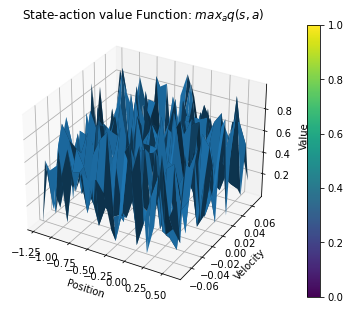

In [4]:
### Example code ###

from runner import FARunner
from environment import Mountain

n_episodes = 1
max_iter=100

env_class = Mountain
agent_class = RandomAgentQ


# Differentiate Between value and q based algorithms
type_values = ["state_action_value","state_value"]


# Running a Single Agent on a single environment.

my_runner = FARunner(env_class(), agent_class(), type_values[0], verbose=True)
final_reward = my_runner.loop(n_episodes,max_iter)


In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_approximation import RBFSampler
from sklearn.pipeline import Pipeline
import numpy as np
import gym
from gym.envs.classic_control import mountain_car
import keyboard
from time import time

def test_agent(agent_class, n_episodes=1, max_iter=100, verbose=False):
    env_class = Mountain
    # Differentiate Between value and q based algorithms
    if "q" in dir(agent_class):
        type_value = "state_action_value"
    elif "v" in dir(agent_class):
        type_value = "state_value"
    # Running a Single Agent on a single environment.
    agent = agent_class()
    my_runner = FARunner(env_class(), agent, type_value, verbose=verbose)
    final_reward = my_runner.loop(n_episodes, max_iter)
    return agent

def play(agent):
    env = gym.make("MountainCar-v0", render_mode="human")
    done = False
    observation = env.reset()[0]
    print("Press q to stop...")
    t = time()
    while not done:
        env.render()
        observation, reward, done, truncated, info = env.step(
            agent.act(observation)
        )  # take a random action
        if keyboard.is_pressed('q'):
            break
    env.close()
    if done:
        print(f'Agent reached goal in {(time()-t):.1f}s')

## Linear approximation of state Value $V(s)$ 

We first are going to consider an parametrized estimation of the value function $$v_\pi(s) \sim \hat{v}(s,\bold{\theta})$$ with parameters $\bold{\theta}$. You can think of the process of generalization in two different ways :
- We simplify the problem by computing similarity elements between states  -> feature learning
- We extend the behavior of the policy to multiple states -> Optimization on a parametrized function class 

### Monte-Carlo State Value Approximation

Q.1 Test the Linear Monte-Carlo State Value Approximation algorithm ( See Sutton Barto, 9.3 and 9.4) 

We are using randomly sampled features to represent the state space. ( see Barto - Sutton 9.5.2) $$ s \sim \bold{x}$$ with $\bold{x} = (x_1,...,x_n)$ is a decomposition on randomly sampled Fourier Coefficients.

In [6]:
class MC_State_Value_Approximation:
    """ MC State-value Learning with Function Approximation
    """

    def __init__(self):
        """
        Init:
            gamma: discount factor
            preprocessing_states: preprocessing state features for better representation
            mdp: instance of environment, allowing to simulate action with self.mdp.step_from_state(current_state, action)
            theta: linear weight (function approximation)
        """
        self.gamma = 0.9
        n_components = 10 # You can change
        self.preprocessing_states = Pipeline([("scaler", StandardScaler()), ("feature_generation", RBFSampler(n_components=n_components))])
        self.preprocessing_states.fit(np.array([[np.random.uniform(-1.2, 0.6), np.random.uniform(-0.07, 0.07)] for _ in range(10000)]))
        self.mdp = Mountain()
        self.theta = np.zeros(n_components) # Linear weight parameters of the linear projection

    def preprocessing(self, state):
        """
        Return the featurized representation of a state.
        """
        return self.preprocessing_states.transform([state])[0]

    def act(self, state):
        """Output optimal action of a given state
        Returns: action in [0, 1, 2]
        """

        Vs = np.array([self.v(self.mdp.step_from_state(state, action)[0]) for action in [0, 1, 2]])
        idx_best = np.argsort(-Vs)

        if np.random.uniform(0, 1) < 0.1:
            return np.random.choice(list(idx_best[1:]))
        else:
            return idx_best[0]

    def update(self, state, action, reward, new_state, terminal):
        """Receive a reward after performing given action.

        This is where your agent can learn. (Update theta.)
        Parameters:
            state: current state
            action: action done in state
            reward: reward received after doing action in state
            new_state: next state
            terminal: boolean if new_state is a terminal state or not
        """
        if terminal:
            self.theta = self.theta + 1e-3 * (reward - self.v(state)) * self.preprocessing(state)
        else:
            done = False
            s = new_state
            i = 1
            target = reward
            while (not done) and (i < 30):
                s, r, done = self.mdp.step_from_state(s, self.act(s))
                target += r * self.gamma**i # actual value functions v 
                i += 1

            self.theta = self.theta + 1e-3 * (target - self.v(state)) * self.preprocessing(state)

    def v(self, state):
        """Final V function.
        Return:
            Value (scalar): V(state)
        """
        #value of the states is computered as a linear projection of the states 
        return np.dot(self.preprocessing(state), self.theta)




Episode  1
Episode  2
Episode  3
Episode  4
Episode  5
Episode  6
Episode  7
Episode  8
Episode  9
Episode  10


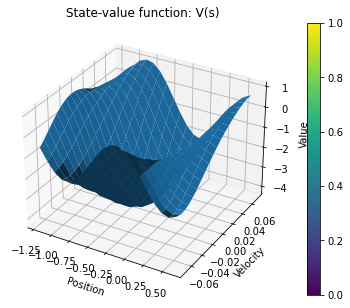

In [8]:
MC_AGENT=test_agent(MC_State_Value_Approximation,n_episodes=10)

In [9]:
play(MC_AGENT)

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/opt/anaconda3/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/keyboard/__init__.py", line 294, in listen
    _os_keyboard.listen(self.direct_callback)
  File "/opt/anaconda3/lib/python3.8/site-packages/keyboard/_darwinkeyboard.py", line 430, in listen
    raise OSError("Error 13 - Must be run as administrator")
OSError: Error 13 - Must be run as administrator


Press q to stop...
Agent reached goal in 12.8s


Q.2 Implement the Linear Semi-Gradient TD(0) : ( See Sutton Barto, 9.3 and 9.4)

In [12]:

class TD0_State_Value_Approximation:
    """ TD(0) State-value Learning with Function Approximation
    """

    def __init__(self):
        """
        Init:
            gamma: discount factor
            preprocessing_states: preprocessing state features for better representation
            mdp: instance of environment, allowing to simulate action with self.mdp.step_from_state(current_state, action)
            theta: linear weight (function approximation)
        """
        self.gamma = 0.9
        n_components = 10 # You can change
        self.preprocessing_states = Pipeline([("scaler", StandardScaler()), ("feature_generation", RBFSampler(n_components=n_components))])
        self.preprocessing_states.fit(np.array([[np.random.uniform(-1.2, 0.6), np.random.uniform(-0.07, 0.07)] for _ in range(10000)]))
        self.mdp = Mountain()
        self.theta = np.zeros(n_components) # Linear weight

    def preprocessing(self, state):
        """
        Return the featurized representation of a state.
        """
        return self.preprocessing_states.transform([state])[0]

    
    def act(self, state):
        """Output optimal action of a given state
        Returns: action in [0, 1, 2]
        """

        Vs = np.array([self.v(self.mdp.step_from_state(state, action)[0]) for action in [0, 1, 2]])
        idx_best = np.argsort(-Vs)

        if np.random.uniform(0, 1) < 0.1:
            return np.random.choice(list(idx_best[1:]))
        else:
            return idx_best[0]


    def update(self, state, action, reward, new_state, terminal):
        """Receive a reward after performing given action.

        This is where your agent can learn. (Update theta.)
        Input:
            state: current state
            action: action done in state
            reward: reward received after doing action in state
            new_state: next state
            terminal: boolean if new_state is a terminal state or not
        """
        target = reward + self.gamma * self.v(new_state)
        self.theta = self.theta + 1e-3* (target - self.v(state)) * self.preprocessing(state) 

    def v(self, state):
        """Final V function.
        Return:
            Value (scalar): V(state)
        """
        #value of the states is computered as a linear projection of the states 
        return np.dot(self.preprocessing(state), self.theta)

Episode  1
Episode  2
Episode  3
Episode  4
Episode  5
Episode  6
Episode  7
Episode  8
Episode  9
Episode  10


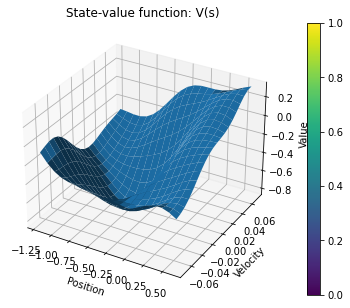

In [13]:
TD0=test_agent(TD0_State_Value_Approximation,n_episodes=10)

In [14]:
play(TD0)

Press q to stop...
Agent reached goal in 8.8s


: 

### n-step-TD State Value Approximation

Q.3 Implement the n-step-TD State Value Approximation

In [7]:

class n_steps_TD_State_Value_Approximation:
    """ TD(lambda) State-value Learning with Function Approximation
    http://www.incompleteideas.net/book/7/node2.html
    """

    def __init__(self):
        """
        Init:
            gamma: discount factor
            preprocessing_states: preprocessing state features for better representation
            mdp: instance of environment, allowing to simulate action with self.mdp.step_from_state(current_state, action)
            theta: linear weight (function approximation)
            lambda_value: Monte-Carlo step
        """
        self.gamma = 0.9
        n_components = 10 # You can change
        self.preprocessing_states = Pipeline([("scaler", StandardScaler()), ("feature_generation", RBFSampler(n_components=n_components))])
        self.preprocessing_states.fit(np.array([[np.random.uniform(-1.2, 0.6), np.random.uniform(-0.07, 0.07)] for _ in range(10000)]))
        self.mdp = Mountain()
        self.theta = np.zeros(n_components) # Linear weight
        self.mc_steps = 5 # Monte Carlo steps

    def preprocessing(self, state):
        """
        Return the featurized representation of a state.
        """
        return self.preprocessing_states.transform([state])[0]

    def act(self, state):
        """Output optimal action of a given state
        Return: action in [0, 1, 2]
        """
        Vs = np.array([self.v(self.mdp.step_from_state(state, action)[0]) for action in [0, 1, 2]])
        idx_best = np.argsort(-Vs)

        if np.random.uniform(0, 1) < 0.1:
            return np.random.choice(list(idx_best[1:]))
        else:
            return idx_best[0]


    def update(self, state, action, reward, new_state, terminal):
        """Receive a reward after performing given action.

        This is where your agent can learn. (Update theta.)
        Input:
            state: current state
            action: action done in state
            reward: reward received after doing action in state
            new_state: next state
            terminal: boolean if new_state is a terminal state or not
        """
        if terminal:
            self.theta = self.theta + 1e-3 * (reward - self.v(state)) * self.preprocessing(state)
        else:
            done = False
            s = new_state
            i = 1
            target = reward
            while (not done) and (i < self.mc_steps):
                s, r, done = self.mdp.step_from_state(s, self.act(s))
                target += r * self.gamma**i # actual value functions v 
                i += 1
            
                
            if not done:
                target+=self.v(s)*self.gamma**self.mc_steps

            self.theta = self.theta + 1e-3 * (target - self.v(state)) * self.preprocessing(state)

    def v(self, state):
        """Final V function.
        Return:
            Value (scalar): V(state)
        """
        #value of the states is computered as a linear projection of the states 
        return np.dot(self.preprocessing(state), self.theta)

Episode  1
Episode  2
Episode  3
Episode  4
Episode  5
Episode  6
Episode  7
Episode  8
Episode  9
Episode  10


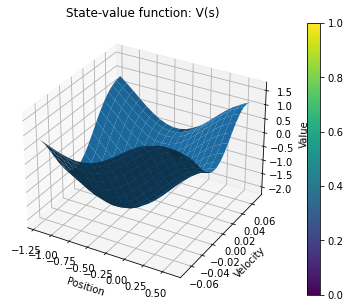

In [8]:
n_steps_TD=test_agent(n_steps_TD_State_Value_Approximation,n_episodes=10)

In [9]:
play(n_steps_TD)

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/opt/anaconda3/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/keyboard/__init__.py", line 294, in listen
    _os_keyboard.listen(self.direct_callback)
  File "/opt/anaconda3/lib/python3.8/site-packages/keyboard/_darwinkeyboard.py", line 430, in listen
    raise OSError("Error 13 - Must be run as administrator")
OSError: Error 13 - Must be run as administrator


Press q to stop...
Agent reached goal in 8.3s


## Linear approximation of state-action Value Q(s, a)

We then  are going to consider an parametrized estimation of the value function $$q_\pi(s,a) \sim \hat{q}(s,a,\bold{\theta})$$ with parameters $\bold{\theta}$. 

Q.4 Implement the TD(0) State-Action Value Approximation

In [14]:
class TD0_Q_Learning_Function_Approximation:
    """ Q-Learning with Function Approximation
    """

    def __init__(self):
        """
        Init:
            gamma: discount factor
            preprocessing_states: preprocessing state features for better representation
            mdp: instance of environment, allowing to simulate action with self.mdp.step_from_state(current_state, action)
            theta: linear weight (function approximation)
        """
        self.gamma = 0.9
        n_components = 10
        self.preprocessing_states = Pipeline([("scaler", StandardScaler()), ("feature_generation", RBFSampler(n_components=n_components))])
        self.preprocessing_states.fit(np.array([[np.random.uniform(-1.2, 0.6), np.random.uniform(-0.07, 0.07)] for _ in range(10000)]))
        self.mdp = Mountain()
        self.list_actions=[0,1,2]
        self.theta = np.zeros(shape=(n_components, len(self.list_actions))) # the weights is going to be matrix, because we have theta of size 10 per action

    def preprocessing(self, state):
        """
        Return the featurized representation of a state.
        """
        return self.preprocessing_states.transform([state])[0]

    def act(self, state):
        """Output optimal action of a given state
        Return: action in [0, 1, 2]
        """
        qs = np.array([self.q(self.mdp.step_from_state(state, action)[0],action) for action in [0, 1, 2]])
        idx_best = np.argsort(-qs)

        if np.random.uniform(0, 1) < 0.1:
            return np.random.choice(list(idx_best[1:]))
        else:
            return idx_best[0]

    def update(self, state, action, reward, new_state, terminal):
        """Receive a reward for performing given action.

        This is where your agent can learn. (Update self.theta)
        Input:
            state: current state
            action: action done in state
            reward: reward received after doing action in state
            new_state: next state
            terminal: boolean if new_state is a terminal state or not
        """
        if terminal:
            q_new_state = 0
        else:
            q_new_state = np.max(self.q(new_state, self.list_actions))#the q takes the action that maximize the q of the new state

        self.theta[:, action] = self.theta[:, action] + 1e-3 * (
            reward + self.gamma * q_new_state - self.q(state, action)
        ) * self.preprocessing(state)


    def q(self, state, action):
        """Final Q function.
            Value (scalar): Q(state, action)
        """
        
        return np.dot(self.preprocessing(state), self.theta[:, action])


Episode  1
Episode  2
Episode  3
Episode  4
Episode  5
Episode  6
Episode  7
Episode  8
Episode  9
Episode  10
Episode  11
Episode  12
Episode  13
Episode  14
Episode  15
Episode  16
Episode  17
Episode  18
Episode  19
Episode  20
Episode  21
Episode  22
Episode  23
Episode  24
Episode  25
Episode  26
Episode  27
Episode  28
Episode  29
Episode  30
Episode  31
Episode  32
Episode  33
Episode  34
Episode  35
Episode  36
Episode  37
Episode  38
Episode  39
Episode  40
Episode  41
Episode  42
Episode  43
Episode  44
Episode  45
Episode  46
Episode  47
Episode  48
Episode  49
Episode  50
Episode  51
Episode  52
Episode  53
Episode  54
Episode  55
Episode  56
Episode  57
Episode  58
Episode  59
Episode  60
Episode  61
Episode  62
Episode  63
Episode  64
Episode  65
Episode  66
Episode  67
Episode  68
Episode  69
Episode  70
Episode  71
Episode  72
Episode  73
Episode  74
Episode  75
Episode  76
Episode  77
Episode  78
Episode  79
Episode  80
Episode  81
Episode  82
Episode  83
Episode  84
E

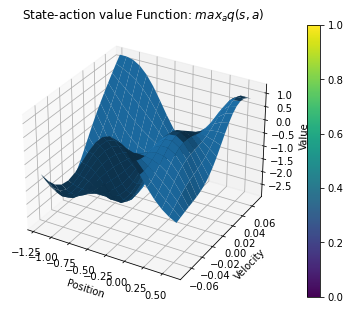

In [17]:
n_steps_TD=test_agent(TD0_Q_Learning_Function_Approximation,n_episodes=10)

## (BONUS ) Deep Q-network

The paper https://arxiv.org/pdf/1312.5602.pdf explore a method of training neural network using Experience Replay. 

You have to store the agent experience (observation,action,reward,next_state) in memory D and apply Q-Learning on samples drawn from D. 

BONUS : Implement the deep Q-network algorithm : https://arxiv.org/pdf/1312.5602.pdf